# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distributions involved. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 20
learning_rate  =  5e-5#1e-3
batch_size = 64
### Choose a value for the size of the latent space
latent_dim = 10

###

# Define here the any extra hyperparameters you used.
beta = 2 #.75 WAS 0.5
###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.,), (1.,)),
])
# (0.5,), (0.5,)

# Modify the denorm function in case you need to do any output transformation when visualizing your images
def interpolate(z1, z2, num=11):
    Z = np.zeros((z1.shape[0], num))
    for i in range(z1.shape[0]):
        Z[i, :] = np.linspace(z1[i], z2[i], num)
    return Z

def denorm_for_tanh(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def denorm_for_sigmoid(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

denorm = denorm_for_sigmoid



## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')

## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*
from torch.nn import Conv2d, ConvTranspose3d, Linear, ReLU, Sequential, Sigmoid
from torch.nn.modules.pooling import MaxPool2d
from torch.distributions.normal import Normal

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Encoding Material
        self.encoder = Sequential(
                                  Linear(784, 980),
                                  ReLU(inplace=True),
                                  Linear(980, 1024),
                                  ReLU(inplace=True),
                                  Linear(1024, 1280),
                                  ReLU(inplace=True),
        )
        self.en_mu_lin = Linear(1280, latent_dim)
        self.en_logvar_lin = Linear(1280, latent_dim)

        # Decoding Material
        self.decoder = Sequential(
                                  Linear(latent_dim, 1280),
                                  ReLU(inplace=True),
                                  Linear(1280, 1024),
                                  ReLU(inplace=True),
                                  Linear(1024, 784),
                                  Sigmoid(),
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.encoder(x.view((-1, 784)))
        # print("MU SIZE: ", mu.size())
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return self.en_mu_lin(x), self.en_logvar_lin(x)
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return mu + torch.exp(logvar*0.5)*torch.randn_like(logvar)


    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.decoder(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x.view((-1, 1, 28, 28))
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x = self.decode(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return x, mu, logvar
    
model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 5240888
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=980, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=980, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
  )
  (en_mu_lin): Linear(in_features=1280, out_features=10, bias=True)
  (en_logvar_lin): Linear(in_features=1280, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


Total number of parameters is: 5240888.

```
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=980, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=980, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
  )
  (en_mu_lin): Linear(in_features=1280, out_features=10, bias=True)
  (en_logvar_lin): Linear(in_features=1280, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
```



## Training loop

In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*
def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        BCE = torch.sum(F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784),
                                                reduction='none'), dim=1)
        Expected_BCE = torch.mean(BCE)   
        Batch_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = Expected_BCE + beta*Batch_KLD
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return loss, Expected_BCE, Batch_KLD

epoch_loss = []
reconstruction_list = []
KLD_list = []
test_loss_lst = []
test_BCE_lst = []
test_KLD_lst = []



for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        model.train()
        train_loss = 0
        reconstruction_loss = 0
        KLD_loss = 0

        for batch_idx, data in enumerate(loader_train):
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            # forward
            recon_batch, mu, logvar = model(img)
            loss, BCE, KLD = loss_function_VAE(recon_batch, img, mu, logvar, beta)
            # backward
            loss.backward()
            train_loss += loss.item()
            reconstruction_loss += BCE.item()
            KLD_loss += KLD.item()
            # print(f"Debug Train: Avg Loss: {loss.item()}, Reconstruction Loss: {BCE.item()} and KLD: {KLD.item()}")
            optimizer.step()
        # print out losses and save reconstructions for every epoch
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss))
        recon = denorm(model(fixed_input.to(device))[0])
        save_image(recon.float(), './CW_VAE/MNIST/reconstructed_epoch_{}.png'.format(epoch))
        print(f"Train: Loss: {train_loss}, Reconstruction Loss: {reconstruction_loss} and KLD Loss: {KLD_loss}")
        epoch_loss.append(train_loss)
        reconstruction_list.append(reconstruction_loss)
        KLD_list.append(KLD_loss)

        model.eval()
        test_loss = 0
        test_BCE = 0
        test_KLD = 0
        with torch.no_grad():
            for img, _ in loader_test:
                img = img.to(device)
                recon_batch, mu, logvar = model(img)
                loss, BCE, KLD = loss_function_VAE(recon_batch, img, mu, logvar, beta)
                test_loss += loss
                test_BCE += BCE
                test_KLD += KLD
            # reconstruct and save the last batch
            recon_batch = model(recon_batch.to(device))
            img = denorm(img.cpu())

        test_loss_lst.append(test_loss)
        test_BCE_lst.append(test_BCE)
        test_KLD_lst.append(test_KLD)
        print(f"Test: Total Loss: {test_loss}, Reconstruction Loss: {test_BCE} and KLD: {test_KLD}")
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

!pip install imageio
import imageio
images = []
for epoch in range(num_epochs):
    images.append(imageio.imread('./CW_VAE/MNIST/reconstructed_epoch_{}.png'.format(epoch)))
imageio.mimsave('/VAE_movie.gif', images)

# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

epoch [1/20], loss:196960.4217
Train: Loss: 196960.42169189453, Reconstruction Loss: 192588.71841430664 and KLD Loss: 2185.8516273526475
Test: Total Loss: 28028.59375, Reconstruction Loss: 26445.349609375 and KLD: 791.6221313476562
epoch [2/20], loss:154353.1937
Train: Loss: 154353.19367980957, Reconstruction Loss: 141276.14517974854 and KLD Loss: 6538.524284362793
Test: Total Loss: 23946.359375, Reconstruction Loss: 21259.103515625 and KLD: 1343.6357421875
epoch [3/20], loss:138858.4886
Train: Loss: 138858.4885559082, Reconstruction Loss: 121705.78896331787 and KLD Loss: 8576.349816799164
Test: Total Loss: 22474.498046875, Reconstruction Loss: 19469.294921875 and KLD: 1502.60009765625
epoch [4/20], loss:132956.6675
Train: Loss: 132956.66749572754, Reconstruction Loss: 114417.203125 and KLD Loss: 9269.732203483582
Test: Total Loss: 21770.515625, Reconstruction Loss: 18595.580078125 and KLD: 1587.4677734375
epoch [5/20], loss:129429.9269
Train: Loss: 129429.9268951416, Reconstruction Lo

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.

## Answer:
The loss function composed of:

$ \mathcal{L} = \sum_i^N \frac{1}{M} \big( \mathbb{E}_{\mathbf{z_i}\sim q_\phi(\mathbf{z}\mid \mathbf{x_i})}[{\log{p_\theta(\mathbf{x_i}|\mathbf{z_i})}] - \beta D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z}))\big)} $

Where $N$ is the size of the *latent vector* and I chose $\beta = ?$. $\mathcal{L}$ is used to maximise the likelihood lower bound.

We use the Binary Cross-entropy loss because we want to maximise the likelihood of the training inputs being reconstructed & BCE can be used to measure the expected probability of our training data under the model. This meant that the model has a sigmoid activation function at the ultimate layer and the original MNIST dataset was transformed by $\mu=0.5$ & $\sigma=0.5$ so that the pixel values were bounded between 0 & 1.

Unfortunately one key disadvantages of using the Binary Cross-entropy loss is that decoded images tend to be blurred. The BCE loss curves for varying desired pixel intensities can be seen below where the x-axis is the predicted pixel intensity and the y axis is the loss. 

> Plot of *Binary Cross Entropy Loss Function*
![image](https://drive.google.com/uc?id=1ccfnhLDIxEHurdV2Q70RPkx8rC7S8Jmr)

Please note that the **arg-minimum of the curve** corresponds to the **desired pixel intensity** (in this example we increment by 0.1 intensity from 0. to 1.). This illustrate that the BCE loss function will generally penalise predicted intensities closs to 0 or 1. This typically results in the model predicting pixel values closer to 0.5 as if the model predicted 0.99 and it was meant to predict 0.9 then the penalty it recieves is much greater than if it had predicted 0.7. 

Within $\mathcal{L}$, KL divergence measures how different the probability distribution is with respect to a reference probability distribution and since $ \mathbf{z_i}\sim\mathcal{N}(0,I) $, then KLD can be written as:

$$ D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z})) = \frac{-1}{2}\sum_{j=1}^N{(1+log(\sigma_{ij}^2)-\mu_{ij}^2-\sigma_{ij}^2)} $$ where $N$ the dimensionality of the latent space. This means that less identical probability distributions will yield a larger positive KL divergence and if they are both identical then the KLD will be 0. Thereofore larger $\beta$ in $\mathcal{L}$ amplifies the loss of KL which limits the size of the latent space, which forces the model to learn the most efficient representation of the data which is the reason why I chose **$\beta=2$**. Unfortunately whilst large $\beta$ can encourage learning a disentangled representation of the MNIST dataset, the quality of the reconstruction is usually compromised, resulting in poorer reconstructions.



## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


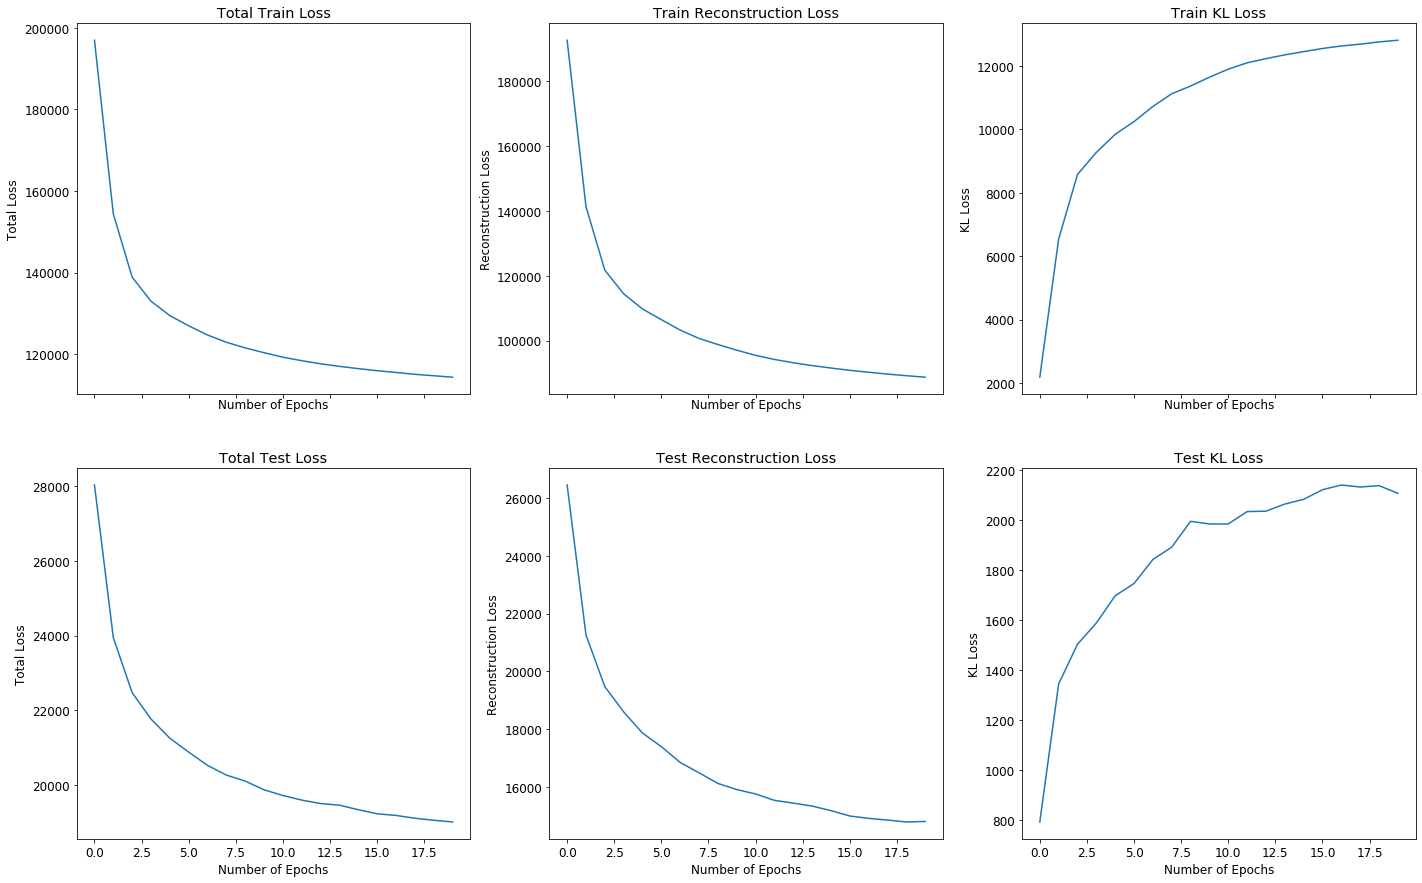

In [0]:
# *CODE FOR PART 1.2a IN THIS CELL*
epochs_list = [i for i in range(len(epoch_loss))]
plt.rcParams.update({'font.size': 12})

fig, ((ax1, ax2, ax3), (ax_1, ax_2, ax_3)) = plt.subplots(2, 3, sharex=True,sharey=False)
fig.set_size_inches(24, 15)
ax1.plot(epochs_list, epoch_loss)
ax1.set_title("Total Train Loss")
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Total Loss')

ax2.plot(epochs_list, reconstruction_list)
ax2.set_title("Train Reconstruction Loss")
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Reconstruction Loss')

ax3.plot(epochs_list, KLD_list)
ax3.set_title("Train KL Loss")
ax3.set_xlabel('Number of Epochs')
ax3.set_ylabel('KL Loss')


# test_f, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, sharey=False)
# test_f.set_size_inches(24, 6)
ax_1.plot(epochs_list, test_loss_lst)
ax_1.set_title("Total Test Loss")
ax_1.set_xlabel('Number of Epochs')
ax_1.set_ylabel('Total Loss')

ax_2.plot(epochs_list, test_BCE_lst)
ax_2.set_title("Test Reconstruction Loss")
ax_2.set_xlabel('Number of Epochs')
ax_2.set_ylabel('Reconstruction Loss')

ax_3.plot(epochs_list, test_KLD_lst)
ax_3.set_title("Test KL Loss")
ax_3.set_xlabel('Number of Epochs')
ax_3.set_ylabel('KL Loss')

plt.savefig('vae_graph.png', transparent=False)

### Your answer to 1.2b here:

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

---



**Beginning:**
The total loss for both training & test is very high but sharply decreases at approximately the same rate that the reconstruction loss decreases, meanwhile the KL loss is slightly increasing. This was expected because despite $\beta=2.0$, the amplified magnitude of the KLD loss is significantly smaller than the reconstruction loss. Making the gradient of the reconstruction loss with respect to the inputs larger than the gradient of KL with respect to the inputs. Therefore the parameters are optimised to primarily reduce the reconstruction loss.


**Towards the end:** There were diminishing returns as the rate of decrease of the total loss approached to zero as the number of epochs increased over time.

For reasons explained above, the KL loss never decreased but this may have changed with sufficiently large $\beta$.


**Posterior Collapse:** During this coursework, I had no problem with posterior collapse but if this did happen then I would expect to see most different latent vectors generating the same small selection of generated images. As at posterior collapse:

>$\beta D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z})) \approx 0$

Meaning:
>$q_\phi(\mathbf{z}|\mathbf{x_i}) \approx p_\theta(\mathbf{z}))$

One way I would mitigate this is to start with $\beta=0$ and once KLD is sufficiently large, incrementally increase $\beta$ during training so that the models optmise their weights with respect to the KL loss. 


torch.Size([256, 1, 28, 28])


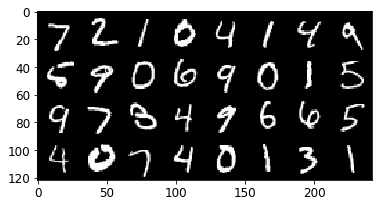

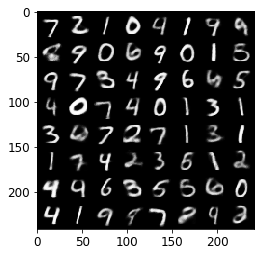

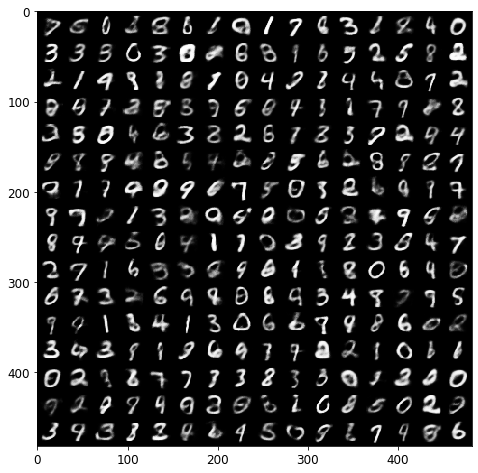

In [0]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
# model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, y = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch = model(sample_inputs.to(device))[0]
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    print(denorm(samples).shape)
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

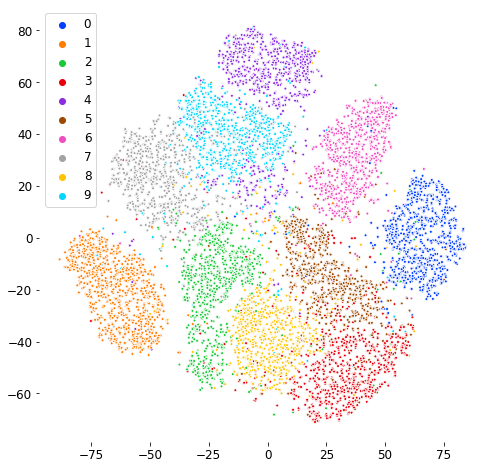

In [0]:
# *CODE FOR PART 1.3a IN THIS CELL*
from sklearn.manifold import TSNE
import seaborn as sns

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################

    tmp_loader_test = DataLoader(test_dat, len(test_dat), shuffle=False)
    test_inputs, test_labels = next(iter(tmp_loader_test))

    mu, logvar = model.encode(test_inputs.to(device))
    z = model.reparametrize(mu, logvar)

    tsne = TSNE(n_jobs=-1)
    Z_embedded = tsne.fit_transform(z.cpu().detach().numpy())

    fig = plt.figure()
    fig.set_size_inches(8, 8)
    palette = sns.color_palette("bright", len(np.unique(test_labels.numpy())))
    sns.scatterplot(Z_embedded[:,0], Z_embedded[:,1], hue=test_labels.numpy(), legend='full', palette=palette, s=8)
    sns.despine(fig, left=True, bottom=True)
    plt.savefig('tsne.png', transparent=False)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #                                             
    ####################################################################### 

### Your answer to 1.3a here:

What do you observe? Discuss the structure of the visualized representations. 

---

**Observations:**

Generally, for my model I see that similar looking digits (ie: 3 & 9) had latent vector distributions that are closer to one another as opposed to 3 & 1 for instance. However it can be seen that the latent variables of 4 are in two clusters around the cluster of latent variables representing the digit 9.

**During my own investigation:**

If $\beta=$0: then the loss function was purely focused on minimising the reconstruction loss. This resulted in the t-SNE that displayed a more disentangled, less utilised capacity of a latent space. A side-effect of this was that if a latent vector is chosen that doesn't belong to a cluster of digits, then the decoded latent vector would be a blurred mixture of the closest digit clusters.

If $\beta$ is sufficiently large: then the loss function would solely minimise the KL loss & the latent vector space would become a perfect Gaussian distribution. Resulting in the visualised representations being completely entangled and the possibility of the model learning the latent representations of the MNIST digits being significantly unlikely as the capacity of the latent channel being too small. 

If $\beta$ is just right: then the latent space would have almost non-overlapping latent variable digit distribution clusters meaning that the latent space is less entangled and a more efficient. This would mean that any interpolated latent vectors between two latent clusters would mostly belong to either of the two clusters.

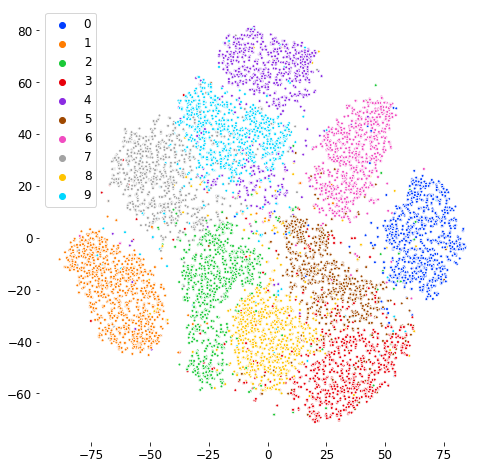

### Your answer to 1.3a here:

torch.Size([1, 784])
(10, 1)
torch.float32


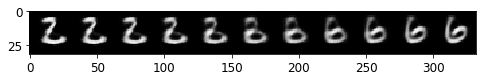

In [0]:
# *CODE FOR PART 1.3b IN THIS CELL*
with torch.no_grad():
    # sample_1 = next(iter(loader_test))[0][3]
    # sample_2 = next(iter(loader_test))[0][9] OG

    sample_1 = next(iter(loader_test))[0][1]
    sample_2 = next(iter(loader_test))[0][11]
    mu1, log1 = model.encode(sample_1.flatten(start_dim=1).to(device))
    mu2, log2 = model.encode(sample_2.flatten(start_dim=1).to(device))
    latent1 = model.reparametrize(mu1, log1)
    latent2 = model.reparametrize(mu2, log2)

    latent_interps = torch.tensor(interpolate(latent1.flatten().cpu().numpy().T, latent2.flatten().cpu().numpy().T).T)
    outputs = model.decode(latent_interps.view(-1, latent_dim).to(device, dtype=torch.float))
    output = make_grid(outputs, nrow=11, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    fig = plt.figure()
    fig.set_size_inches(8, 24)
    plt.savefig('interpolated_digits.png', transparent=False)
    show(output)

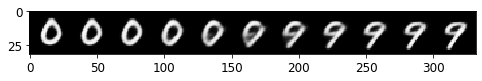

**Example 1:**
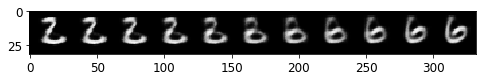

### Your answer to 1.3b here:
b. What do you observe regarding the transition from on digit to the other?

---

**Model Observations:**

In general, I observed that the latent vectors closest to the original latent vectors tended to be decoded into digits that resembled the original digits. **Example 1** illustrates that as the latent representations of 2 & 6 are interpolated, the ~50:50 mixed latent vectors decoded to form roughly 8's.

**During my own investigation:**

If $\beta=0$ or close to 0:
Then this would give almost perfect digit constructions for latent vectors  sampled from that digit's cluster. But since $\beta=0$ (or sufficiently small) then latent space would be very disentangled. This can result in a latent vector drawn from the latent space that doesn't belong to any known cluster that represents a digit, then the decoder, will generate a blurred digit of mostly medium pixel intensity. As the decoder hasn't had to decode any latent vectors during training that are similar to this latent vector.

If Beta is sufficiently large:
Then the decoded interpolated latent vectors would either be a complete blur as all the digit latent vector distributions would perfectly mix with eachother as the latent channel capacity is too small for the model to learn a latent representation of the MNIST dataset as seen from **1.3a**. 

If Beta is just right:
Then the latent channel capacity is optimal such that the latent representations are efficiently learnt, with almost non-overlapping clusters representing the distributions of each digits latent representation space. This would mean that any interpolated values would be variants of the same digit as it's closest point that was interpolated on. We would see a perfect switch from the left digit to the right digit as we transition from the left half of the decoded values to the right half.

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [0]:
batch_size = 64  # change that 256
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 100
learning_rate  = 0.0002
latent_vector_size = 100
###

# Define here other hyperparameters that you used.

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d( latent_vector_size, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.decoder(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.judge = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.judge(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1068928
Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 691584
Discriminator(
  (judge): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1,

Total number of parameters in Generator is: 1068928
```
Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
```

Total number of parameters in Discriminator is: 691584
```
Discriminator(
  (judge): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
```

Total number of parameters is: 1760512

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.45
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):

    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0): 
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()

        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

!pip install imageio
import imageio
images = []
for epoch in range(num_epochs):
    images.append(imageio.imread('./CW_DCGAN/fake_samples_epoch_%03d.png' % epoch))
imageio.mimsave('/GAN_movie.gif', images)
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

[0/100][0/766] Loss_D: 1.4536 Loss_G: 1.1095 D(x): 0.5673 D(G(z)): 0.5736 / 0.3391
[0/100][1/766] Loss_D: 1.3121 Loss_G: 1.1976 D(x): 0.5405 D(G(z)): 0.4815 / 0.3131
[0/100][2/766] Loss_D: 1.1771 Loss_G: 1.2777 D(x): 0.5682 D(G(z)): 0.4389 / 0.2871
[0/100][3/766] Loss_D: 1.1510 Loss_G: 1.3510 D(x): 0.5750 D(G(z)): 0.4285 / 0.2690
[0/100][4/766] Loss_D: 1.0646 Loss_G: 1.4376 D(x): 0.6141 D(G(z)): 0.4201 / 0.2460
[0/100][5/766] Loss_D: 1.0206 Loss_G: 1.5191 D(x): 0.6197 D(G(z)): 0.4011 / 0.2279
[0/100][6/766] Loss_D: 1.0340 Loss_G: 1.5760 D(x): 0.6300 D(G(z)): 0.4213 / 0.2140
[0/100][7/766] Loss_D: 1.0695 Loss_G: 1.6421 D(x): 0.6134 D(G(z)): 0.4140 / 0.2034
[0/100][8/766] Loss_D: 1.1340 Loss_G: 1.6086 D(x): 0.5920 D(G(z)): 0.4291 / 0.2095
[0/100][9/766] Loss_D: 1.0484 Loss_G: 1.7418 D(x): 0.6490 D(G(z)): 0.4347 / 0.1858
[0/100][10/766] Loss_D: 1.0765 Loss_G: 1.7738 D(x): 0.6263 D(G(z)): 0.4329 / 0.1812
[0/100][11/766] Loss_D: 1.0387 Loss_G: 1.9501 D(x): 0.6206 D(G(z)): 0.4006 / 0.1543
[0

KeyboardInterrupt: ignored

### Your answer to 2.1c here:
c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

---

**Experimentations**

Originally I experimented with my own architectures. Naively believing it would not be too difficult to generate images but by the end of the first 48hrs had decided it would be better to start with a base-line architecture from the Pytorch DCGAN's tutorial. This immediately showed to me that my original learning rates of around 0.001 were too high and likely the culprit to the discriminator learning to correctly identify the fakes created by the generator before the generator had much of a chance to learn. All this experimentation showed to me how instable GANs are and mode collapse is a huge problem for them. 

**Mode collapse** was a huge problem during my initial creative streak to improvise a working architecture. Where if the generator suffers mode collapse on a subset of still very unrealistic images, then the disriminator was very capable of identifying them as fakes. Later on with variants of the base-case architecture from the tutorials, the mode collapse I noticed was that the generator's only realistic images tending to only be horses & cars with other images being too distorted to really recognise.

**Example of having a bad architecture**
>![image](https://drive.google.com/uc?id=17bRSc_ZP7MOy6DF1ZubFzacJGV05x9oM)

**Adjusting capacity** by increasing the number of filters in my convolutional layers led to the generator picking up on some finer details like wheel caps on vehicles but it also led to an awkward seesaw problem where increasing the capacity of both networks could easily result in the discriminator being able to get the upper hand on the generator too quickly causing mode collapse before any identifiable images to be created. My solution for this coursework was to fix the parameter capacity of the discriminator and only tailor the learning rates and capacity of the generator to try and achieve in training some equilibrium.


**Final Architecture**
#### Generator
*   Fully Convolutional Transpose 2D layers - were chosen as an easy way to upsample and I chose convolutional layers instead of fully connected layers here because they required less parameters which meant I could create models with a smaller number of parameters which allowed for faster training.
*   Batch Normalisation 2D - these standardize the activations from a prior layer to have zero mean and unit variance which in return improves the stability of learning. Stability here is important as they GANs are notoriously unstable.
*   ReLU - to make the model a non-linear function approximator whilst avoid sigmoid & tanh which are infamous for gradient vanish and can be computationally costly which ReLU completely avoids.

#### Discriminator
*   Fully Convolutional 2D layers - as an easy way to downsample, they are shift invariant & the rest of the reasons are the same as above.
*   Batch Normalisation 2D - for the same reason as above.
*   LeakyReLU - used for the same reason as above but has also been shown to be successful in some papers.


Total number of parameters in Generator is: 1068928
```
Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
```

Total number of parameters in Discriminator is: 691584
```
Discriminator(
  (judge): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
```

Total number of parameters is: 1760512
Why start & end layers are different?

### Generator samples

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

fig = plt.figure()
fig.set_size_inches(8, 8)
show(img)

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    fig = plt.figure()
    fig.set_size_inches(12, 24)
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12, 9)
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.show()

### ANSWER FOR PART 2.2 IN THIS CELL*

At the start, the fake images generated were mostly identical and had no real structure. However, the generator loss sharply decreased whilst the Discriminator loss increased. This is because the generator is learning to create partially realistic images & this is affecting the performance of the discriminator to correctly classify the images as real or generated (fake). 

When equilibrium was reached, where the loss of both models was constant for several epochs, the fake images began to look slightly more realistic as parts of animals limbs or the rough body of a car began to be identifiable. At this point both the generator had learnt to generate some fakes that fooled the discriminator, but at the same time the discriminator was also learning to identify these fakes and classify properly. 

After some more epochs, we begin to see these two loss curves diverge, as the discrimator loss decreases & the generator's loss increases. Just after divergence I saw the "clearest" fakes that looked most realistic. The divergence was caused by the discriminator who began to learn how to identify the generated pictures quicker than the generator is able to learn to generate better images. **Once reason for the generator starting to perform worse could be because the model has reached a local minimum or full capacity. ???**

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

# ANSWER FOR PART 2.3 IN THIS CELL*

Mode collapse refers to the problem where the generator only generates a smaller subset of the multi-modal data that the GAN was trained on. This happened in nearly every run, whether it was every fake picture being complete unidentifiable noise or the generator only clearly producing images of horses and cars. This generally occurs when the generator becomes only good at generating a couple of types of images and as to minimise the loss function imposed on the generator, it optimises on the class distributions it has learnt best. 

To mitigate this
























I used the L1 Loss function because the error penalty is linear, it is more robost and generally less affected by outliers in contrast to L2 Loss. What do I mean by outliers in the MNIST context? Well it could be digits that are taller and wider than its family. 

I used 
